In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mlflow.tracking import MlflowClient
import corner
from astropy.cosmology import Planck18
import torch
import zuko
import pandas as pd
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"
#device = "cpu"
print(f'Using device: {device}.')

desi_data = pd.read_csv('/home/ashandonay/bed/desi_data.csv')

Using device: cuda:0.


In [2]:
def compare_plot(exp_name, var):

    client = MlflowClient()
    exp_id = client.get_experiment_by_name(exp_name).experiment_id
    run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params[var]))
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
    full_loss = []
    for i, run_id in enumerate(run_ids):
        loss_history = client.get_metric_history(run_id, 'loss')
        losses = [metric.value for metric in loss_history]
        full_loss.append(losses)
        steps = len(losses)
        artifact_uri = client.get_run(run_id).info.artifact_uri
        sigma = client.get_run(run_id).data.params[var]
        eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
        ax2.plot(eigs, alpha=0.7, label=f"{var}={sigma}", linestyle='--', color=colors[i])
        brute_force_eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/brute_force_eigs.npy")
        ax2.plot(brute_force_eigs, color=colors[i])
    loss = np.array(full_loss)
    for i, run_id in enumerate(run_ids):
        loss_history = client.get_metric_history(run_id, 'loss')
        losses = [metric.value for metric in loss_history]
        full_loss.append(losses)
        steps = len(losses)
        artifact_uri = client.get_run(run_id).info.artifact_uri
        sigma = client.get_run(run_id).data.params[var]
        ax1.plot(np.arange(steps)*25, loss[i,:]-loss.min(), alpha=0.5, color=colors[i], label=f"{var}={sigma}")

    ax1.set_xlabel("Training Step")
    ax1.set_ylabel("Loss")
    ax1.set_yscale('log')
    ax2.set_xlabel("Design (redshift)")
    ax2.set_ylabel("Expected Information Gain [bits]")
    ax1.legend()
    plt.show()

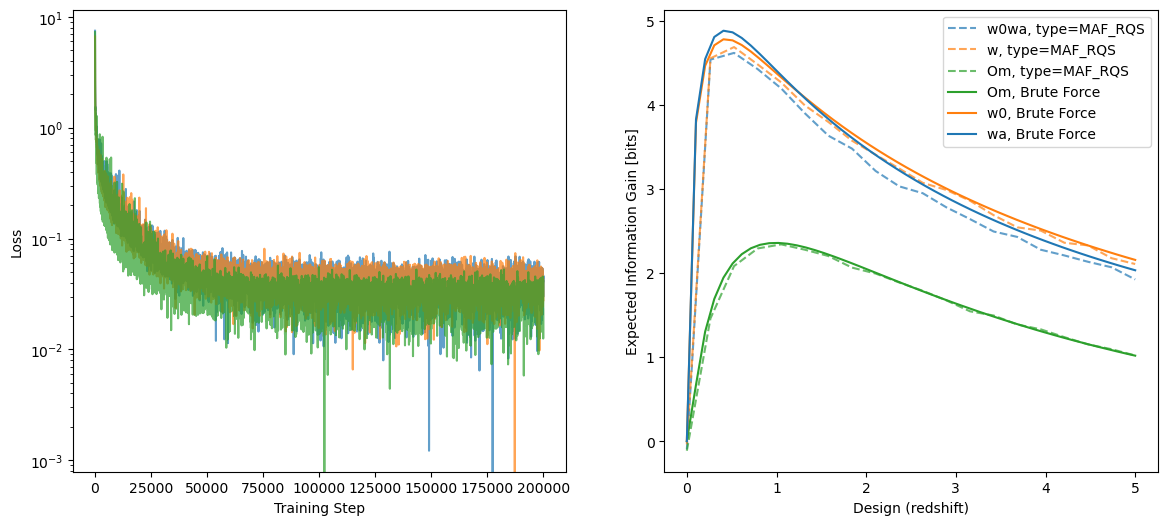

In [13]:
client = MlflowClient()
exp_name = 'NF_Cosmology_zuko'
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
cosmos = ['Om', 'w', 'w0wa']

for run_id in run_ids[0:3]:
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    steps = len(losses)
    ax1.plot(np.arange(steps)*25, losses-np.array(losses).min(), alpha=0.7)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    flow_type = client.get_run(run_id).data.params['flow_type']
    eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
    ax2.plot(eigs[:,0], eigs[:,1], alpha=0.7, label=f"{cosmos.pop()}, type={flow_type}", linestyle='--')
om_grid_eigs = np.load("grid_Om_eigs.npy")
w_grid_eigs = np.load("grid_w_eigs.npy")
w0wa_grid_eigs = np.load("grid_w0wa_eigs.npy")
ax2.plot(om_grid_eigs[:, 0], om_grid_eigs[:, 1], label="Om, Brute Force", color='tab:green')
ax2.plot(w_grid_eigs[:, 0], w_grid_eigs[:, 1], label="w0, Brute Force", color='tab:orange')
ax2.plot(w0wa_grid_eigs[:, 0], w0wa_grid_eigs[:, 1], label="wa, Brute Force", color='tab:blue')

ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.set_yscale('log')
ax2.set_xlabel("Design (redshift)")
ax2.set_ylabel("Expected Information Gain [bits]")
plt.legend()
plt.show()

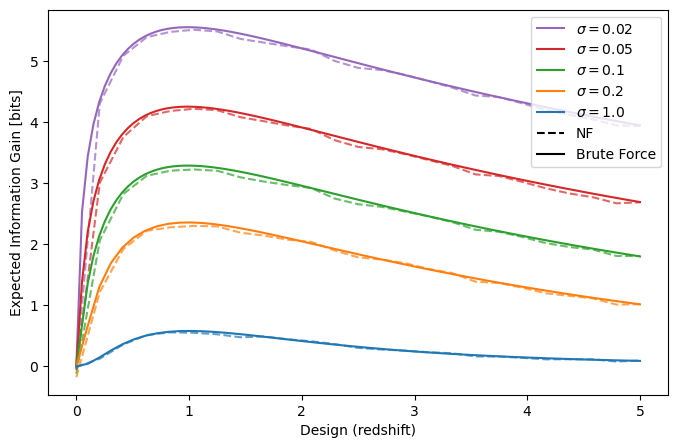

In [2]:
client = MlflowClient()
exp_name = 'NF_Cosmology_sigma'
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

fig, ax1 = plt.subplots(1, 1, figsize=(8, 5))
cosmos = ['Om', 'w', 'w0wa']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

# order run_ids by sigma
run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params['D_H_error']))
run_ids.remove('902195545ab3483991203840a33a2111')

for run_id in run_ids:
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    steps = len(losses)
    #ax1.plot(np.arange(steps)*25, losses-np.array(losses).min(), alpha=0.7)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    sig = client.get_run(run_id).data.params['D_H_error']
    if sig in ['0.5', '2.0']:
        continue
    eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
    color = colors.pop()
    ax1.plot(eigs[:,0], eigs[:,1], alpha=0.7, color=color, linestyle='--')
    if float(sig) == 0.02:
        grids_eigs_002 = np.load("grid_Om_eigs_0.02.npy")
        ax1.plot(grids_eigs_002[:, 0], grids_eigs_002[:, 1], color=color, label=f"$\sigma={sig}$")
    elif float(sig) == 0.05:
        grids_eigs_005 = np.load("grid_Om_eigs_0.05.npy")
        ax1.plot(grids_eigs_005[:, 0], grids_eigs_005[:, 1], color=color, label=f"$\sigma={sig}$")
    elif float(sig) == 0.1:
        grids_eigs_01 = np.load("grid_Om_eigs_0.1.npy")
        ax1.plot(grids_eigs_01[:, 0], grids_eigs_01[:, 1], color=color, label=f"$\sigma={sig}$")
    elif float(sig) == 0.2:
        grids_eigs_02 = np.load("grid_Om_eigs_0.2.npy")
        ax1.plot(grids_eigs_02[:, 0], grids_eigs_02[:, 1], color=color, label=f"$\sigma={sig}$")
    elif float(sig) == 0.5:
        grid_eigs_05 = np.load("grid_Om_eigs_0.5.npy")
        ax1.plot(grid_eigs_05[:, 0], grid_eigs_05[:, 1], color=color, label=f"$\sigma={sig}$")
    elif float(sig) == 1.0:
        grid_eigs_1 = np.load("grid_Om_eigs_1.0.npy")
        ax1.plot(grid_eigs_1[:, 0], grid_eigs_1[:, 1], color=color, label=f"$\sigma={sig}$")
    elif float(sig) == 2.0:
        grid_eigs_2 = np.load("grid_Om_eigs_2.0.npy")
        ax1.plot(grid_eigs_2[:, 0], grid_eigs_2[:, 1], color=color, label=f"$\sigma={sig}$")

# add extra legend for linestyle
ax1.plot([], [], linestyle='--', color='black', label='NF')
ax1.plot([], [], color='black', label='Brute Force')
ax1.set_xlabel("Design (redshift)")
ax1.set_ylabel("Expected Information Gain [bits]")
plt.legend()
plt.show()

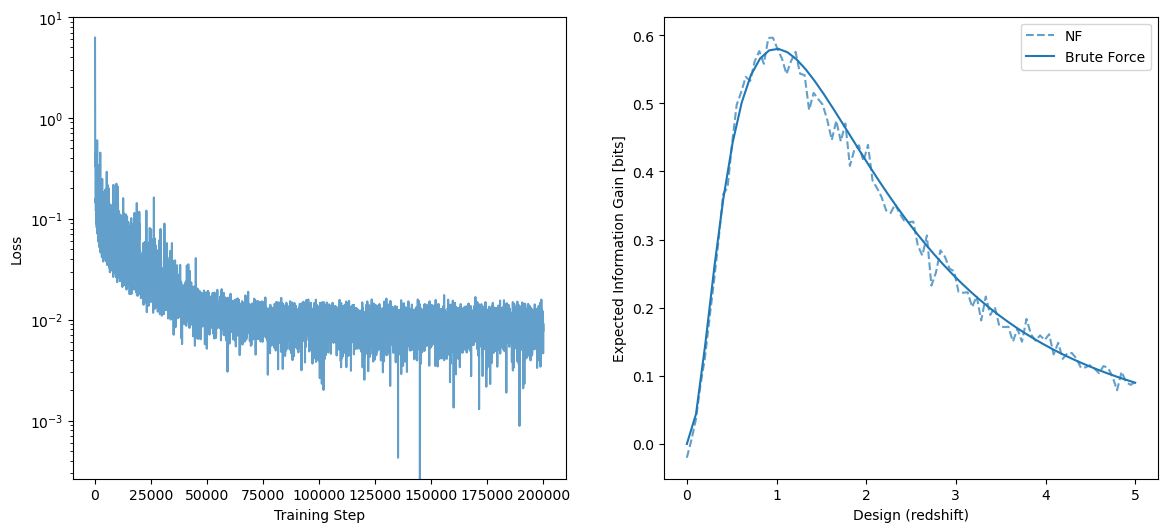

In [65]:
client = MlflowClient()
exp_name = 'NF_Cosmology_sigma'
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_id = '902195545ab3483991203840a33a2111'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
cosmos = ['Om', 'w', 'w0wa']


loss_history = client.get_metric_history(run_id, 'loss')
losses = [metric.value for metric in loss_history]
steps = len(losses)
#ax1.plot(np.arange(steps)*25, losses-np.array(losses).min(), alpha=0.7)
artifact_uri = client.get_run(run_id).info.artifact_uri
sig = client.get_run(run_id).data.params['D_H_error']
eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
ax1.plot(np.arange(steps)*25, losses-np.array(losses).min(), alpha=0.7)
ax2.plot(eigs[:,0], eigs[:,1], alpha=0.7, color="tab:blue", linestyle='--', label="NF")
grid_eigs_1 = np.load("grid_Om_eigs_1.0.npy")
ax2.plot(grid_eigs_1[:, 0], grid_eigs_1[:, 1], color="tab:blue", label="Brute Force")

ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.set_yscale('log')
ax2.set_xlabel("Design (redshift)")
ax2.set_ylabel("Expected Information Gain [bits]")
plt.legend()
plt.show()

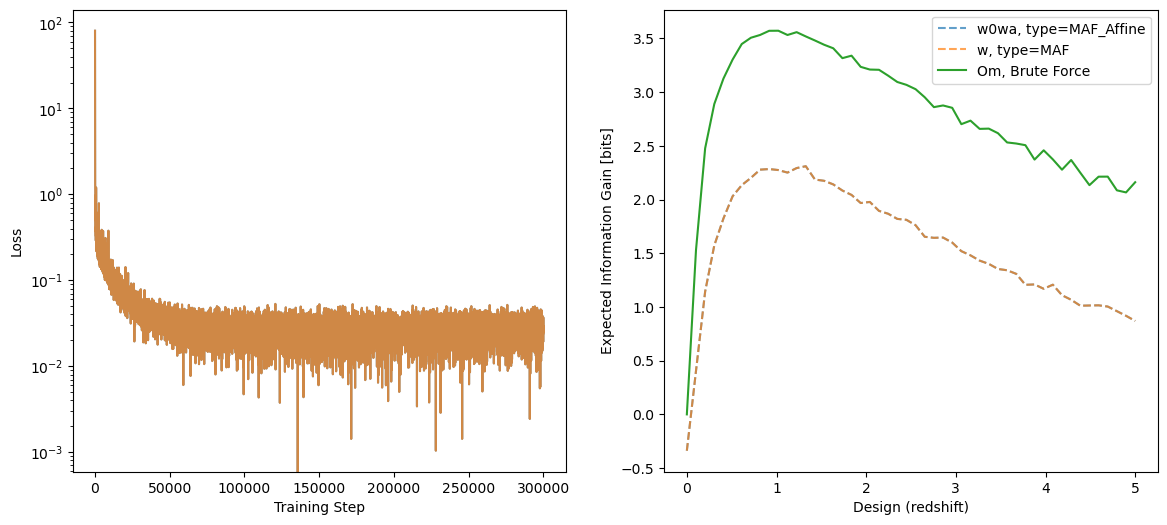

In [9]:
client = MlflowClient()
exp_name = 'NF_Cosmology_type'
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
cosmos = ['Om', 'w', 'w0wa']

for run_id in run_ids[1:3]:
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    steps = len(losses)
    ax1.plot(np.arange(steps)*25, losses-np.array(losses).min(), alpha=0.7)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    flow_type = client.get_run(run_id).data.params['flow_type']
    eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
    ax2.plot(eigs[:,0], eigs[:,1], alpha=0.7, label=f"{cosmos.pop()}, type={flow_type}", linestyle='--')
om_grid_eigs = np.load("grid_Om_eigs.npy")
w_grid_eigs = np.load("grid_w_eigs.npy")
w0wa_grid_eigs = np.load("grid_w0wa_eigs.npy")
ax2.plot(om_grid_eigs[:, 0], om_grid_eigs[:, 1], label="Om, Brute Force", color='tab:green')
#ax2.plot(w_grid_eigs[:, 0], w_grid_eigs[:, 1], label="w0, Brute Force", color='tab:orange')
#ax2.plot(w0wa_grid_eigs[:, 0], w0wa_grid_eigs[:, 1], label="wa, Brute Force", color='tab:blue')

ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.set_yscale('log')
ax2.set_xlabel("Design (redshift)")
ax2.set_ylabel("Expected Information Gain [bits]")
plt.legend()
plt.show()

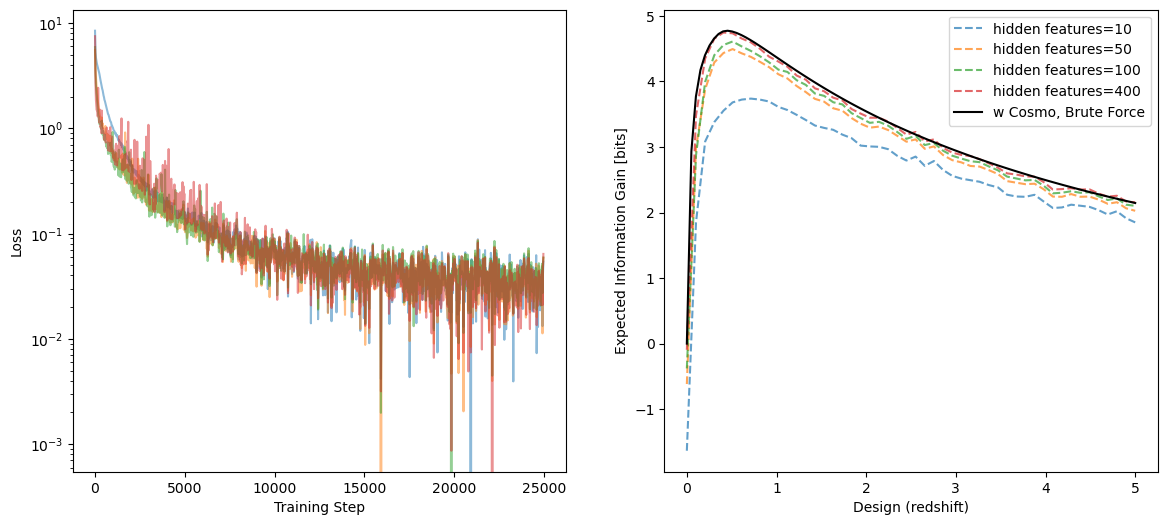

In [8]:
client = MlflowClient()
exp_name = 'NF_Cosmology_features'
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
cosmos = ['Om', 'w', 'w0wa']
run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params['hidden']))
for run_id in run_ids:
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    steps = len(losses)
    ax1.plot(np.arange(steps)*25, losses-np.array(losses).min(), alpha=0.5)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    hidden_features = client.get_run(run_id).data.params['hidden']
    eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
    ax2.plot(eigs[:,0], eigs[:,1], alpha=0.7, label=f"hidden features={hidden_features}", linestyle='--')
w_grid_eigs = np.load("grid_w_eigs.npy")
ax2.plot(w_grid_eigs[:, 0], w_grid_eigs[:, 1], label="w Cosmo, Brute Force", color='black')
#ax2.plot(w0wa_grid_eigs[:, 0], w0wa_grid_eigs[:, 1], label="wa, Brute Force", color='tab:blue')

ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.set_yscale('log')
ax2.set_xlabel("Design (redshift)")
ax2.set_ylabel("Expected Information Gain [bits]")
plt.legend()
plt.show()

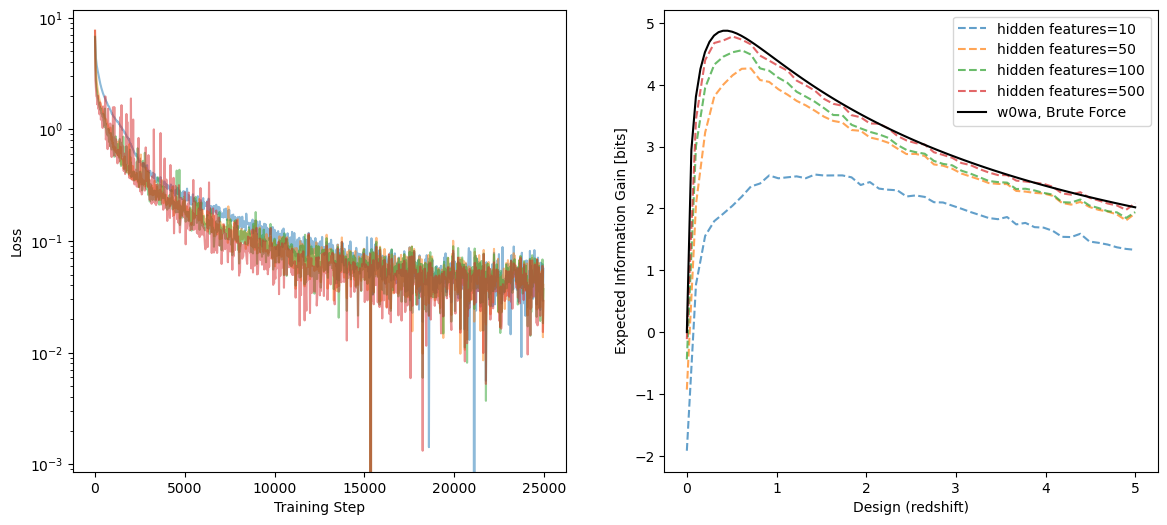

In [13]:
client = MlflowClient()
exp_name = 'w0wa_Cosmology_features'
exp_id = client.get_experiment_by_name(exp_name).experiment_id
run_ids = [run.info.run_id for run in client.search_runs(exp_id)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
cosmos = ['Om', 'w', 'w0wa']

run_ids = sorted(run_ids, key=lambda x: float(client.get_run(x).data.params['hidden']))
run_ids.remove('0ece32cd43c04807ad02f595a91abd34')
for run_id in run_ids:
    loss_history = client.get_metric_history(run_id, 'loss')
    losses = [metric.value for metric in loss_history]
    steps = len(losses)
    ax1.plot(np.arange(steps)*25, losses-np.array(losses).min(), alpha=0.5)
    artifact_uri = client.get_run(run_id).info.artifact_uri
    hidden_features = client.get_run(run_id).data.params['hidden']
    eigs = np.load(f"mlruns/{exp_id}/{run_id}/artifacts/eigs.npy")
    ax2.plot(eigs[:,0], eigs[:,1], alpha=0.7, label=f"hidden features={hidden_features}", linestyle='--')
w0wa_grid_eigs = np.load("grid_w0wa_eigs.npy")
ax2.plot(w0wa_grid_eigs[:, 0], w0wa_grid_eigs[:, 1], label="w0wa, Brute Force", color='black')

ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss")
ax1.set_yscale('log')
ax2.set_xlabel("Design (redshift)")
ax2.set_ylabel("Expected Information Gain [bits]")
plt.legend()
plt.show()